In [3]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde

import seaborn as sns

In [17]:
## Input
# training_filename = '/panfs/ccds02/nobackup/projects/hls/HLS/mwooten3/hls_agb/data/vector/zonal_point_stats_vis/l2al4a_metrics_HLS.30m-annual.2020.2022-point_vis.gpkg'
training_filename = '/projects/my-private-bucket/HLS-1DCNN-AGB/data/shp/gedi/test/l4a_t90km_t89_veg2022_outrm_zonal_HLS.gpkg'

# === MODEL PARAMETERS ===
target_col = "agbd"

random_state = 42

In [18]:
training_df = gpd.read_file(training_filename)
training_df_backup = training_df.copy()

In [19]:
training_df.columns

Index(['time', 'beam', 'elevation', 'shot_number', 'flags', 'sensitivity',
       'orbit', 'solar_elevation', 'track', 'agbd', 'year', 'month',
       'vegmask_2022', 'zone', 'HLS.2022-01-01.2022-12-31.Blue_mean',
       'HLS.2022-01-01.2022-12-31.EVI_mean',
       'HLS.2022-01-01.2022-12-31.EVI2_mean',
       'HLS.2022-01-01.2022-12-31.Green_mean',
       'HLS.2022-01-01.2022-12-31.MSAVI_mean',
       'HLS.2022-01-01.2022-12-31.NBR_mean',
       'HLS.2022-01-01.2022-12-31.NBR2_mean',
       'HLS.2022-01-01.2022-12-31.NDMI_mean',
       'HLS.2022-01-01.2022-12-31.NDVI_mean',
       'HLS.2022-01-01.2022-12-31.NIR_mean',
       'HLS.2022-01-01.2022-12-31.Red_mean',
       'HLS.2022-01-01.2022-12-31.SAVI_mean',
       'HLS.2022-01-01.2022-12-31.SWIR_mean',
       'HLS.2022-01-01.2022-12-31.SWIR2_mean',
       'HLS.2022-01-01.2022-12-31.TCB_mean',
       'HLS.2022-01-01.2022-12-31.TCG_mean',
       'HLS.2022-01-01.2022-12-31.TCW_mean',
       'HLS.2022-01-01.2022-12-31.Xgeo_mean',
       '

In [20]:
# remove outliers

In [21]:
#######################################
# Defining  predictors 
#######################################
# vis2model = (".NDVI", ".SAVI", ".EVI2")
# vis2model = (".NDVI")
vis2model = (
    # ".Red_median",
    # ".Green_median",
    # ".Blue_median",
    # ".NIR_Narrow_median",
    "SWIR1_mean",
    "SWIR2_mean",
    # VIS
    "NDVI_mean",
    'NDMI_mean',
    # ".EVI",
    "EVI2_mean",
    # ".SAVI",
    "MSAVI_mean",
    'TCB_mean',
    'TCG_mean',
    'TCW_mean',
    'Xgeo_mean',
    'Ygeo_mean'
)


hls_cols = [
    col for col in training_df.columns
    if col.startswith("HLS") and 
        col.endswith(vis2model)
]


hls_cols[:3]

['HLS.2022-01-01.2022-12-31.EVI2_mean',
 'HLS.2022-01-01.2022-12-31.MSAVI_mean',
 'HLS.2022-01-01.2022-12-31.NDMI_mean']

In [22]:
# Define train validation split
train_df, val_df = train_test_split(training_df, test_size=0.3, random_state=random_state)


In [29]:
# len(val_df)

In [23]:
X_train_vi = train_df[hls_cols].dropna()
y_train_vi = train_df.loc[X_train_vi.index, target_col]

X_val_vi = val_df[hls_cols].dropna()
y_val_vi = val_df.loc[X_val_vi.index, target_col]

In [26]:
rf_vi = RandomForestRegressor(n_estimators=1000, random_state=random_state, n_jobs=-1)
rf_vi.fit(X_train_vi, y_train_vi)
y_pred_vi = rf_vi.predict(X_val_vi)

/opt/conda/envs/pangeo/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


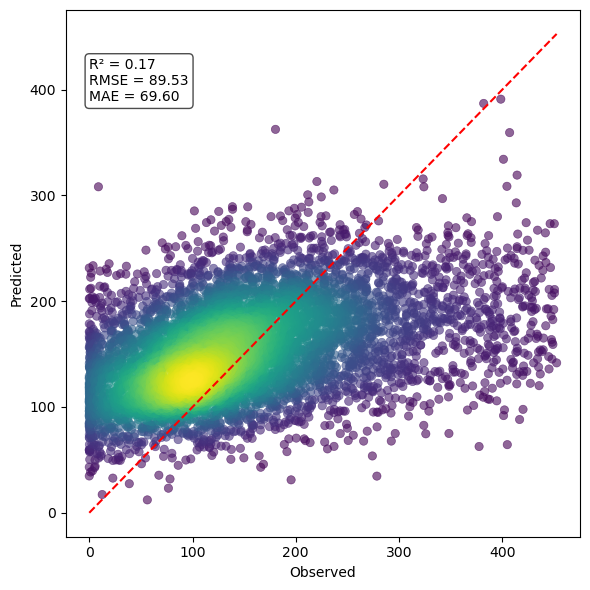

In [27]:

# Plot test 2
# Prepare data
xy = np.vstack([y_val_vi, y_pred_vi])
z = gaussian_kde(xy)(xy)

# Create DataFrame for seaborn
df_plot = pd.DataFrame({
    'Observed': y_val_vi,
    'Predicted': y_pred_vi,
    'Density': z
})

# Sort by density
df_plot = df_plot.sort_values(by='Density')

# Calculate metrics
r2_rf = r2_score(df_plot['Observed'], df_plot['Predicted'])
rmse_rf = mean_squared_error(df_plot['Observed'], df_plot['Predicted'], squared=False)
mae_rf = mean_absolute_error(df_plot['Observed'], df_plot['Predicted'])

# Plot
plt.figure(figsize=(6, 6))
sns.scatterplot(data=df_plot, x='Observed', y='Predicted', hue='Density',
                palette='viridis', edgecolor=None, alpha=0.6, legend=False)

# 1:1 line
min_val = min(df_plot['Observed'].min(), df_plot['Predicted'].min())
max_val = max(df_plot['Observed'].max(), df_plot['Predicted'].max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red')

# Labels
plt.xlabel("Observed")
plt.ylabel("Predicted")

# Remove title and grid
plt.grid(False)

# Add metrics to plot
plt.text(min_val, max_val * 0.95,
         f"R² = {r2_rf:.2f}\nRMSE = {rmse_rf:.2f}\nMAE = {mae_rf:.2f}",
         verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.7))

plt.tight_layout()
plt.show()